<center> <h1>Climatology models

This notebook proposes different type of climatology baseline using linear regression

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_path = "/home/egauillard/data/PR_era5_MED_1degr_19400101_20240229_new.nc"
ds = xr.open_dataset(dataset_path)

## 1- Linear reg - monthly models

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.linear_model import LinearRegression
import pandas as pd 

class ClimatologyMonthlyLinearReg:
    def __init__(self, data: xr.DataArray, var: str, split_years: dict):
        self.data = data
        self.split_years = split_years
        self.var = var
        self.models = {}
        self.train_years = split_years["train"]
        self.test_years = split_years["test"]
        self.month_means = {month: self.get_average_by_month(month) for month in range(1, 13)}
        self.month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                         7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
        
        self._train_models()

    def get_average_by_month(self, month: int):
        month_data = self.data[self.var].where(self.data['time.month'] == month, drop=True)
        mean_data = month_data.groupby("time.year").sum(dim=['time', 'latitude', 'longitude'])
        return mean_data

    def _train_models(self):
        for month in range(1, 13):
            month_mean = self.month_means[month]
            self.train_years = [year for year in self.train_years if year in month_mean.year]
            train_data = month_mean.sel(year=self.train_years)
            x_train = np.array(train_data.year).reshape(-1, 1)
            y_train = np.array(train_data)
            model = LinearRegression()
            model.fit(x_train, y_train)
            self.models[month] = model

    def predict(self, year: int, month: int):
        if month in self.models:
            model = self.models[month]
            prediction = model.predict(np.array([[year]]))
            return prediction[0]
        else:
            raise ValueError("Model for month {} is not trained.".format(month))

    def evaluate(self):
        results = {}
        combined_data = []
        for month in range(1, 13):
            month_means = self.month_means[month]
            test_data = month_means.sel(year=self.test_years)
            x_test = np.array(test_data.year).reshape(-1, 1)
            y_test = np.array(test_data)

            if month in self.models:
                model = self.models[month]
                y_pred = model.predict(x_test)
                mse = np.mean((y_test - y_pred) ** 2)
                results[month] = {'y_test': y_test, 'y_pred': y_pred, 'mse': mse}
                
                for i, year in enumerate(self.test_years):
                    combined_data.append({'year': year, 'month': month, 'y_test': y_test[i], 'y_pred': y_pred[i]})
            else:
                results[month] = {'y_test': None, 'y_pred': None, 'mse': None}
        
        combined_df = pd.DataFrame(combined_data)
        combined_df['date'] = pd.to_datetime(combined_df[['year', 'month']].assign(day=1))
        combined_df = combined_df.sort_values('date')
        
        average_mse = np.mean([result['mse'] for result in results.values() if result['mse'] is not None])
        return results, average_mse, combined_df
    
    def plot_yearly_results(self):
        results, _, combined_df = self.evaluate()
        
        plt.figure(figsize=(20, 10))  # Augmentation de la taille de la figure
        
        x_test = combined_df['date']
        y_test = combined_df['y_test']
        y_pred = combined_df['y_pred']
        
        plt.plot(x_test, y_test, label='Ground Truth', marker='o', color='purple', linewidth=2, markersize=8)
        plt.plot(x_test, y_pred, label='Predicted', marker='x', color='orange', linewidth=2, markersize=8)
        
        plt.title('Results on Test Set: Ground Truth vs Predicted', fontsize=24, fontweight='bold', pad=20)
        plt.xlabel('Date', fontsize=25, labelpad=10)
        plt.ylabel(self.var, fontsize=25, labelpad=10)
        
        plt.legend(fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.xticks(rotation=45, ha='right')
        
        # Ajuster automatiquement l'espacement des dates sur l'axe x
        plt.gcf().autofmt_xdate()
        
        # Ajouter une marge autour du graphique
        plt.margins(x=0.09)
        
        plt.tight_layout()
        plt.show()

    def plot_test_results(self):
        results, _, _ = self.evaluate()
        
        fig, axs = plt.subplots(2, 6, figsize=(20, 10))
        axs = axs.flatten()
        
        # Trouver les valeurs min et max globales
        y_min = float('inf')
        y_max = float('-inf')
        for month in range(1, 13):
            result = results[month]
            if result['y_test'] is not None:
                y_test = result['y_test']
                y_pred = result['y_pred']
                y_min = min(y_min, y_test.min(), y_pred.min())
                y_max = max(y_max, y_test.max(), y_pred.max())
        
        for month in range(1, 13):
            result = results[month]
            if result['y_test'] is not None:
                x_test = self.month_means[month].sel(year=self.test_years).year
                y_test = result['y_test']
                y_pred = result['y_pred']
                
                ax = axs[month - 1]
                ax.plot(x_test, y_test, label='y_test', marker='o', color='purple')
                ax.plot(x_test, y_pred, label='y_pred', marker='x', color='orange')
                ax.set_title(f'Month {self.month_mapping[month]}')
                ax.set_xlabel('Year')
                ax.set_ylabel(self.var)
                ax.legend()
                
                # Définir la même échelle y pour tous les graphiques
                ax.set_ylim(y_min, y_max)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.suptitle('Results on test set : ground truth vs predicted for every month', fontsize=16)
        plt.show()

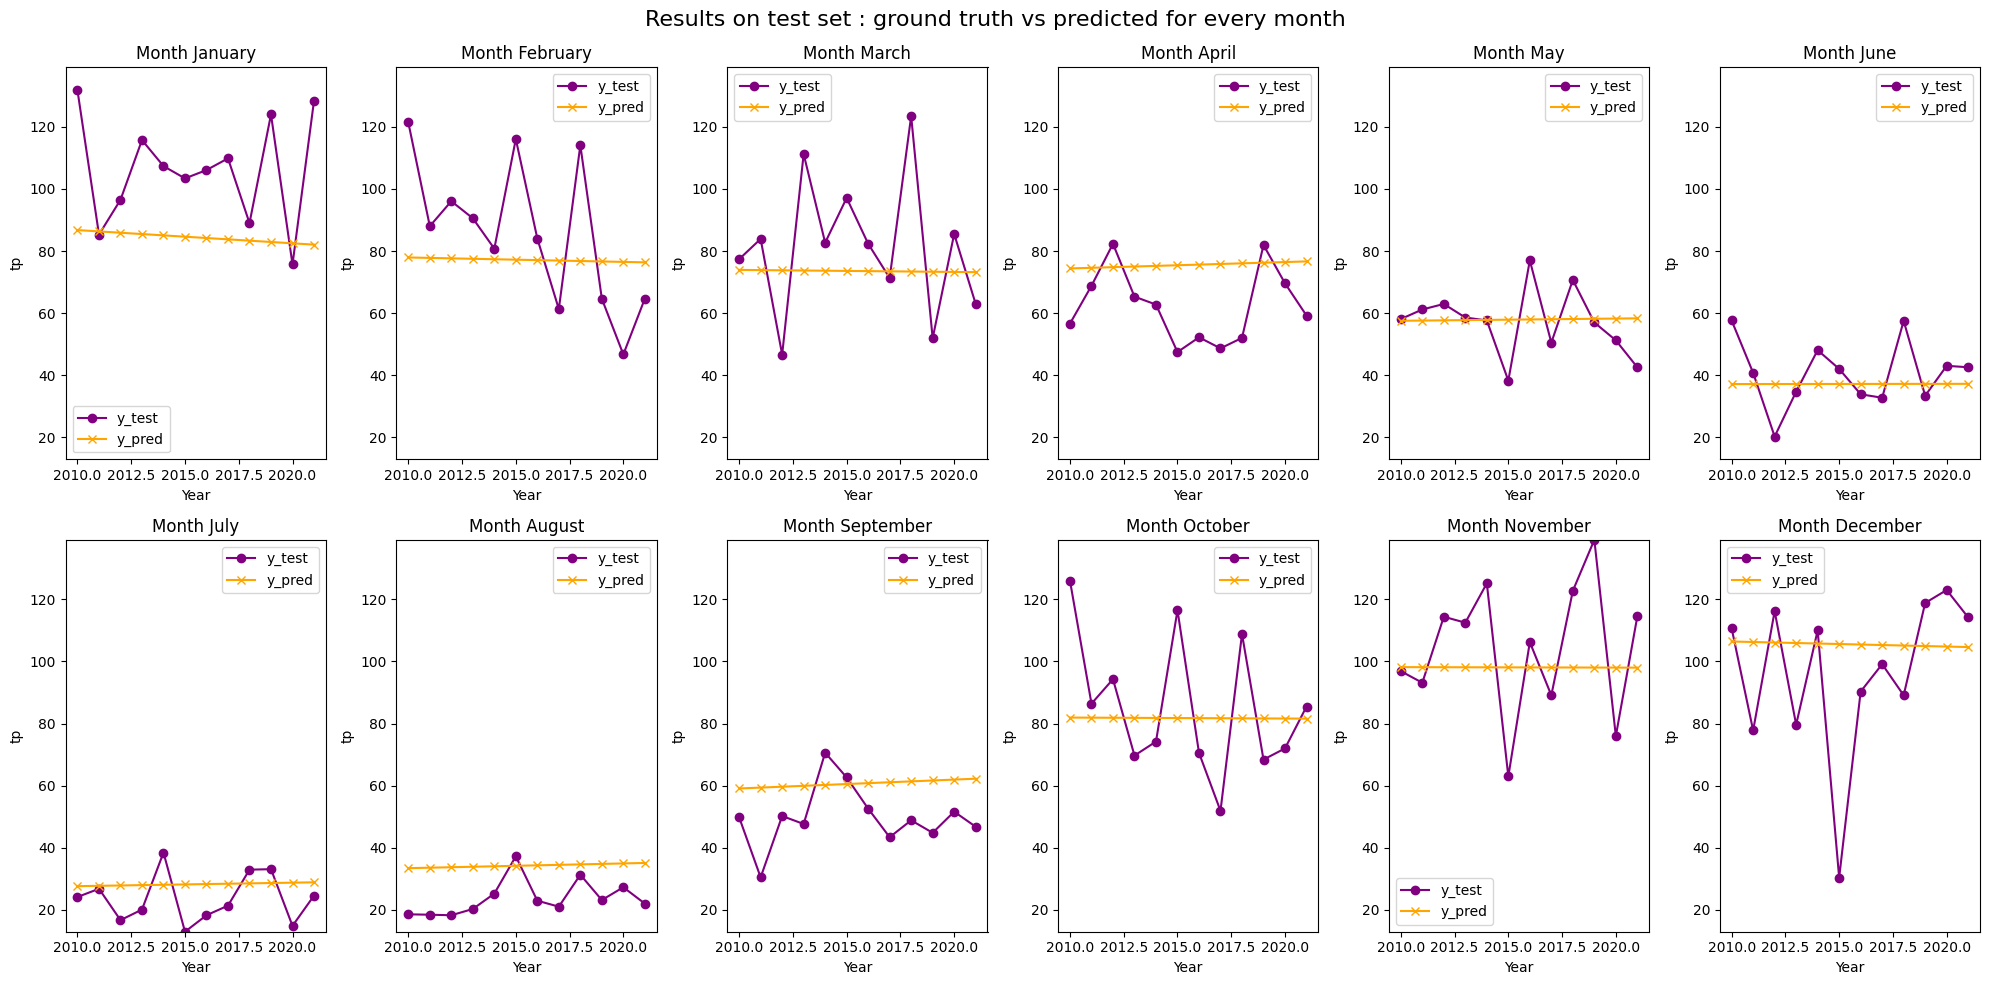

In [4]:
climatology_month_models= ClimatologyMonthlyLinearReg(ds, 'tp', split_years={"train": list(range(1940, 2010)), "test": list(range(2010, 2022))})
climatology_month_models.plot_test_results()

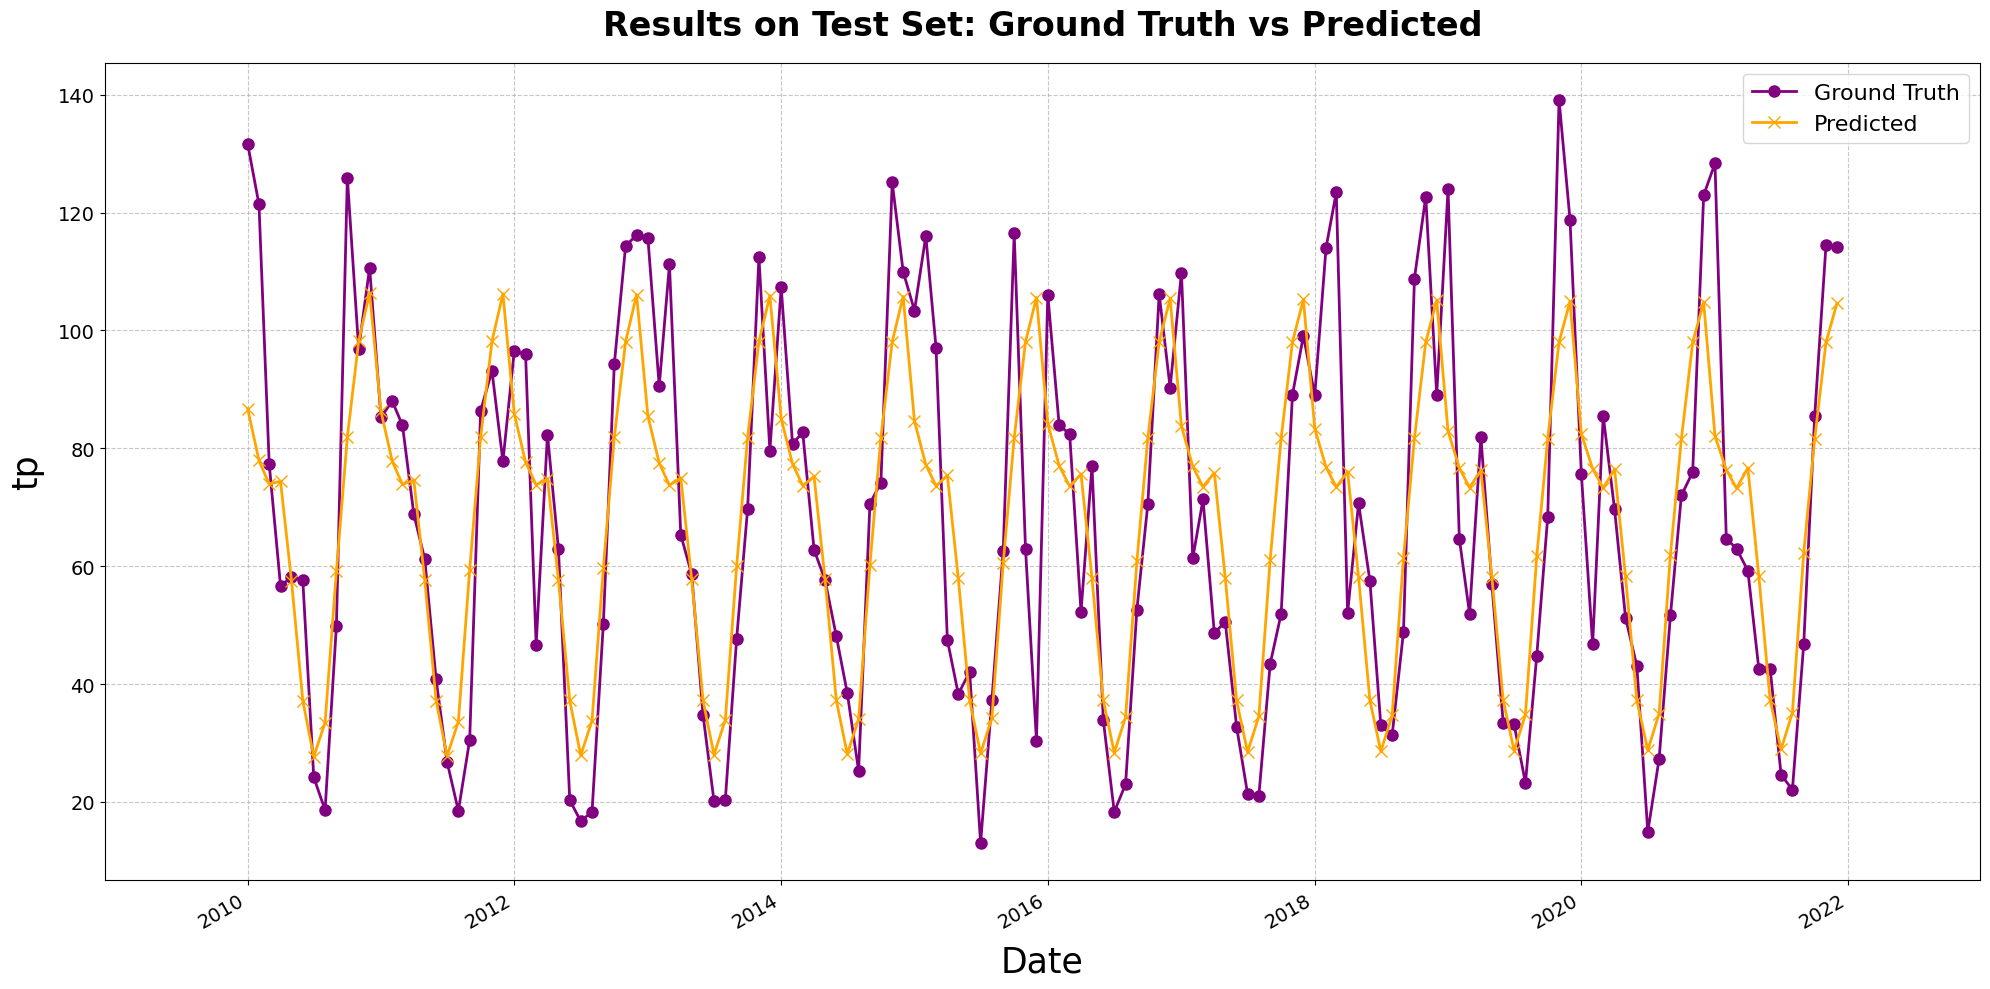

In [5]:
climatology_month_models.plot_yearly_results()

In [6]:
# evaaliate 
results, average_mse, combined_df = climatology_month_models.evaluate()
print("Average MSE: ", average_mse)

Average MSE:  368.4254018849252


## 2- Linear Reg - Continuous model

In [7]:
data_df = pd.DataFrame()

for month in range(1, 13):
    month_data = ds["tp"].where(ds['time.month'] == month, drop=True)
    mean_data_month = month_data.groupby("time.year").mean(dim=['time', 'latitude', 'longitude']).to_dataframe().reset_index()
    mean_data_month["month"] = month
    data_df = pd.concat([data_df, mean_data_month], ignore_index=True)

data_df = data_df.rename(columns={'year': 'year', 'month': 'month', 'tp': 'monthly_mean'})
data_df = data_df[['year', 'month', 'monthly_mean']]
    

print(data_df)



      year  month  monthly_mean
0     1940      1      0.002718
1     1941      1      0.002644
2     1942      1      0.002597
3     1943      1      0.002627
4     1944      1      0.001477
...    ...    ...           ...
1005  2019     12      0.002475
1006  2020     12      0.002562
1007  2021     12      0.002378
1008  2022     12      0.001901
1009  2023     12      0.001666

[1010 rows x 3 columns]


In [8]:
data_df = pd.DataFrame()
for year in range(2010, 2022):
    year_data = ds.sel(time=str(year))
    if len(year_data.time) == 0:
        continue
        
    year_df = year_data.groupby('time.month').mean(dim=['time', 'latitude', 'longitude']).to_dataframe().reset_index()
    year_df['year'] = year
    data_df = pd.concat([data_df, year_df])

data_df = data_df.rename(columns={'tp': 'monthly_mean'})[['year', 'month', 'monthly_mean']]


In [9]:
print(data_df)

    year  month  monthly_mean
0   2010      1      0.002832
1   2010      2      0.002891
2   2010      3      0.001664
3   2010      4      0.001259
4   2010      5      0.001250
..   ...    ...           ...
7   2021      8      0.000474
8   2021      9      0.001040
9   2021     10      0.001838
10  2021     11      0.002545
11  2021     12      0.002378

[144 rows x 3 columns]


In [10]:
print(data_df[data_df['year'].isin(climatology_month_models.test_years)])

    year  month  monthly_mean
0   2010      1      0.002832
1   2010      2      0.002891
2   2010      3      0.001664
3   2010      4      0.001259
4   2010      5      0.001250
..   ...    ...           ...
7   2021      8      0.000474
8   2021      9      0.001040
9   2021     10      0.001838
10  2021     11      0.002545
11  2021     12      0.002378

[144 rows x 3 columns]


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.linear_model import LinearRegression
import pandas as pd

class ClimatologyMonthlyLinearReg:
    def __init__(self, data: xr.DataArray, var: str, split_years: dict):
        self.data = data
        self.split_years = split_years
        self.var = var
        # remove 1947 from train years
        self.train_years = split_years["train"]
        if 1947 in self.train_years:
            self.train_years.remove(1947)
        self.test_years = split_years["test"]
        self.model = None
        
        self._train_model()

    def _prepare_data(self, years):
        data_df = pd.DataFrame()

        for year in years:
            year_data = self.data.sel(time=str(year))
            if len(year_data.time) == 0:
                continue
            
            year_df = year_data.groupby('time.month').sum(dim=['time', 'latitude', 'longitude']).to_dataframe().reset_index()
            year_df['year'] = year
            data_df = pd.concat([data_df, year_df])

        data_df = data_df.rename(columns={self.var: 'monthly_mean'})[['year', 'month', 'monthly_mean']]
        return data_df



    def _train_model(self):
        self.train_data = self._prepare_data(self.train_years)
        self.train_data['month_sin'] = np.sin(2 * np.pi * self.train_data['month'] / 12)
        self.train_data['month_cos'] = np.cos(2 * np.pi * self.train_data['month'] / 12)

        x_train = self.train_data[['year', 'month_sin', 'month_cos']]
        y_train = self.train_data['monthly_mean']

        self.model = LinearRegression()
        self.model.fit(x_train, y_train)

    def predict(self, year: int, month: int):
        if self.model is not None:
            month_sin = np.sin(2 * np.pi * month / 12)
            month_cos = np.cos(2 * np.pi * month / 12)
            prediction = self.model.predict(np.array([[year, month_sin, month_cos]]))
            return prediction[0]
        else:
            raise ValueError("The model has not been trained.")

    def evaluate(self):
        self.test_data = self._prepare_data(self.test_years)
        self.test_data['month_sin'] = np.sin(2 * np.pi * self.test_data['month'] / 12)
        self.test_data['month_cos'] = np.cos(2 * np.pi * self.test_data['month'] / 12)

        x_test = self.test_data[['year', 'month_sin', 'month_cos']]
        y_test = self.test_data['monthly_mean']
        y_pred = self.model.predict(x_test)

        results = {'y_test': y_test, 'y_pred': y_pred}
        mse = np.mean((y_test - y_pred) ** 2)
        
        return results, mse


    def plot_yearly_results(self):
        results, _ = self.evaluate()
        
        self.test_data['y_pred'] = results['y_pred']
        self.test_data['index'] = pd.to_datetime(self.test_data[['year', 'month']].assign(day=1))
        
        # Calculer les limites globales pour l'axe y
        y_min = min(self.test_data['monthly_mean'].min(), self.test_data['y_pred'].min())
        y_max = max(self.test_data['monthly_mean'].max(), self.test_data['y_pred'].max())
        y_range = y_max - y_min
        y_min -= 0.1 * y_range
        y_max += 0.1 * y_range
        
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        x_test = self.test_data['index']
        y_test = self.test_data['monthly_mean']
        y_pred = self.test_data['y_pred']
        
        ax.plot(x_test, y_test, label='Ground Truth', marker='o', color='purple')
        ax.plot(x_test, y_pred, label='Predicted', marker='x', color='orange')
        ax.set_title('Results on Test Set: Ground Truth vs Predicted', fontsize=14)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel(self.var, fontsize=12)
        ax.legend(fontsize=10)
        ax.set_ylim(y_min, y_max)
        
        plt.tight_layout()
        plt.show()

    def plot_test_results(self):
        results, _ = self.evaluate()
        
        self.test_data['y_pred'] = results['y_pred']
        self.test_data['index'] = pd.to_datetime(self.test_data[['year', 'month']].assign(day=1))
        
        # Calculer les limites globales pour l'axe y
        y_min = min(self.test_data['monthly_mean'].min(), self.test_data['y_pred'].min())
        y_max = max(self.test_data['monthly_mean'].max(), self.test_data['y_pred'].max())
        y_range = y_max - y_min
        y_min -= 0.1 * y_range
        y_max += 0.1 * y_range
        
        fig, axs = plt.subplots(2, 6, figsize=(20, 10))
        axs = axs.flatten()
        
        for month in range(1, 13):
            month_data = self.test_data[self.test_data['month'] == month]
            x_test = month_data['index']
            y_test = month_data['monthly_mean']
            y_pred = month_data['y_pred']
            
            ax = axs[month - 1]
            ax.plot(x_test, y_test, label='Ground Truth', marker='o', color='purple')
            ax.plot(x_test, y_pred, label='Predicted', marker='x', color='orange')
            ax.set_title(f'Month: {month}', fontsize=12)
            ax.set_xlabel('Date', fontsize=10)
            ax.set_ylabel(self.var, fontsize=10)
            ax.legend(fontsize=8)
            ax.set_ylim(y_min, y_max)
            
            # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle('Test Results: Actual vs Predicted for Each Month', fontsize=16)
        plt.show()


In [12]:
climatology = ClimatologyMonthlyLinearReg(ds, 'tp', split_years={"train": list(range(1940, 2010)), "test": list(range(2010, 2022))})

In [13]:
results, average_mse = climatology.evaluate()
print(f"Average MSE: {average_mse}")

Average MSE: 354.47058839500266


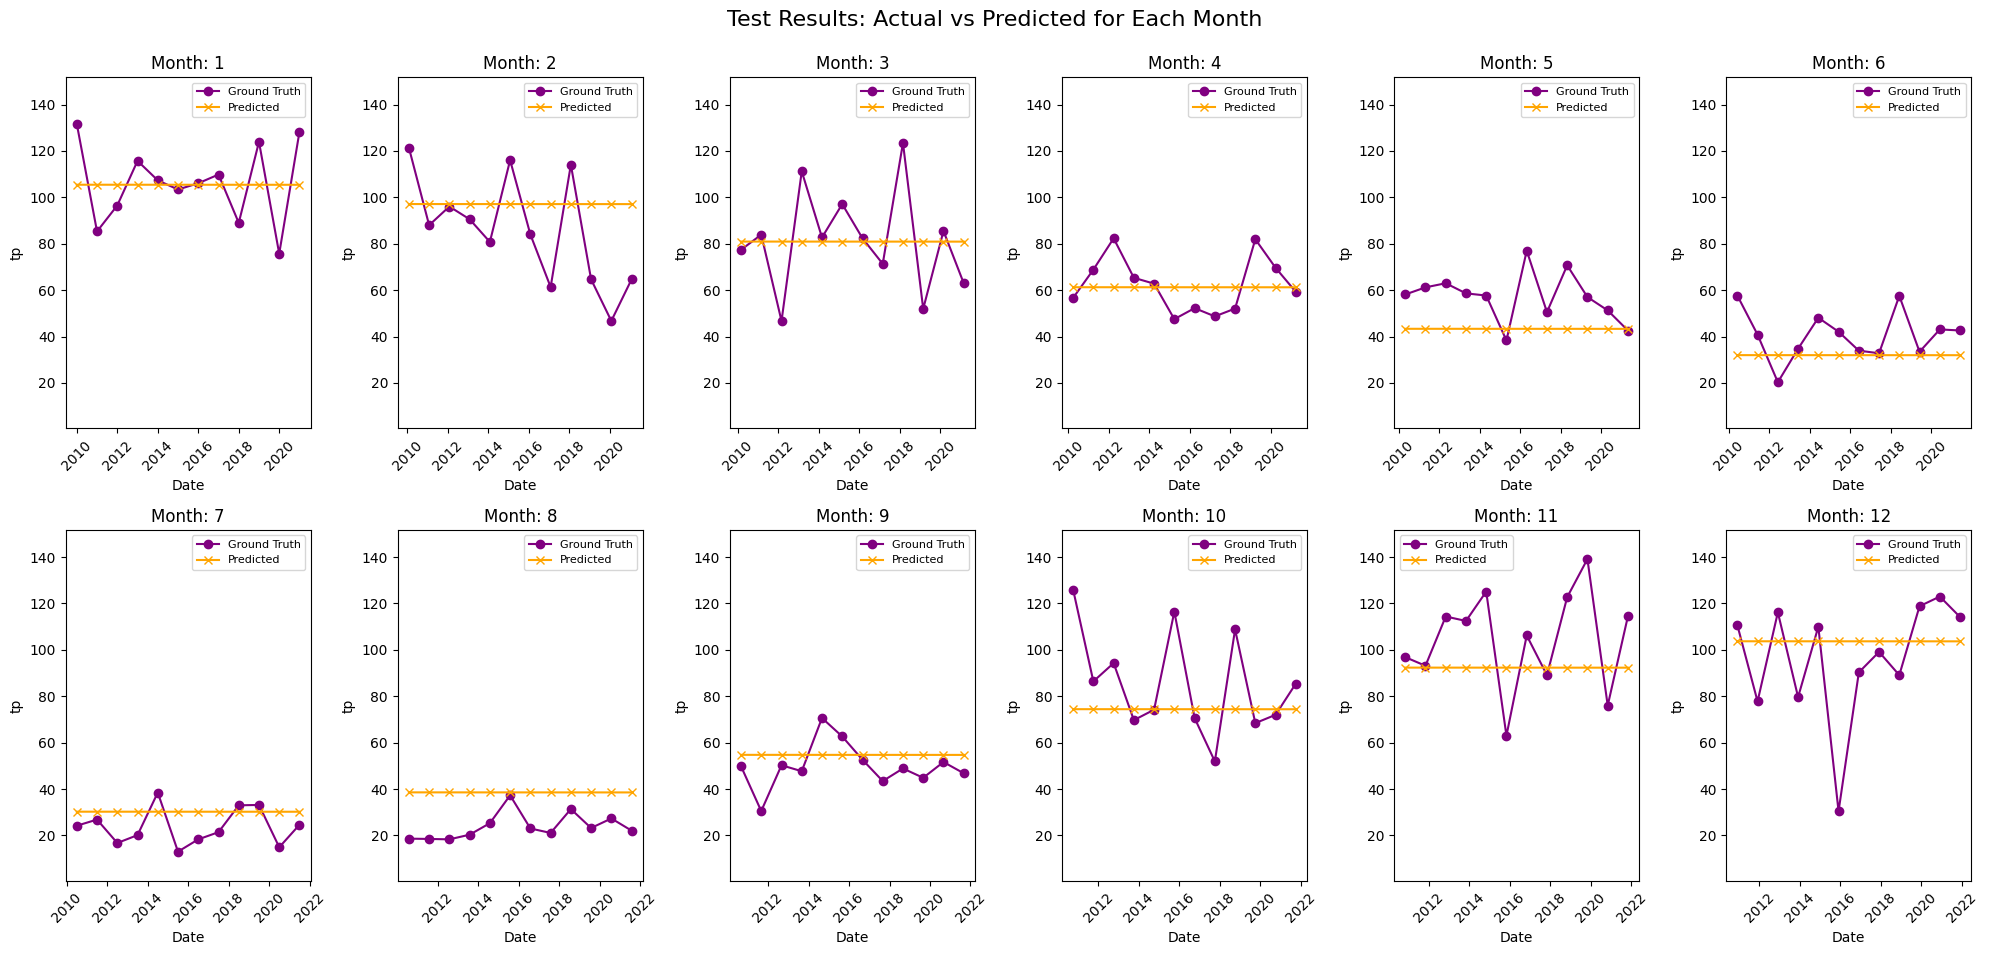

In [14]:
climatology.plot_test_results()

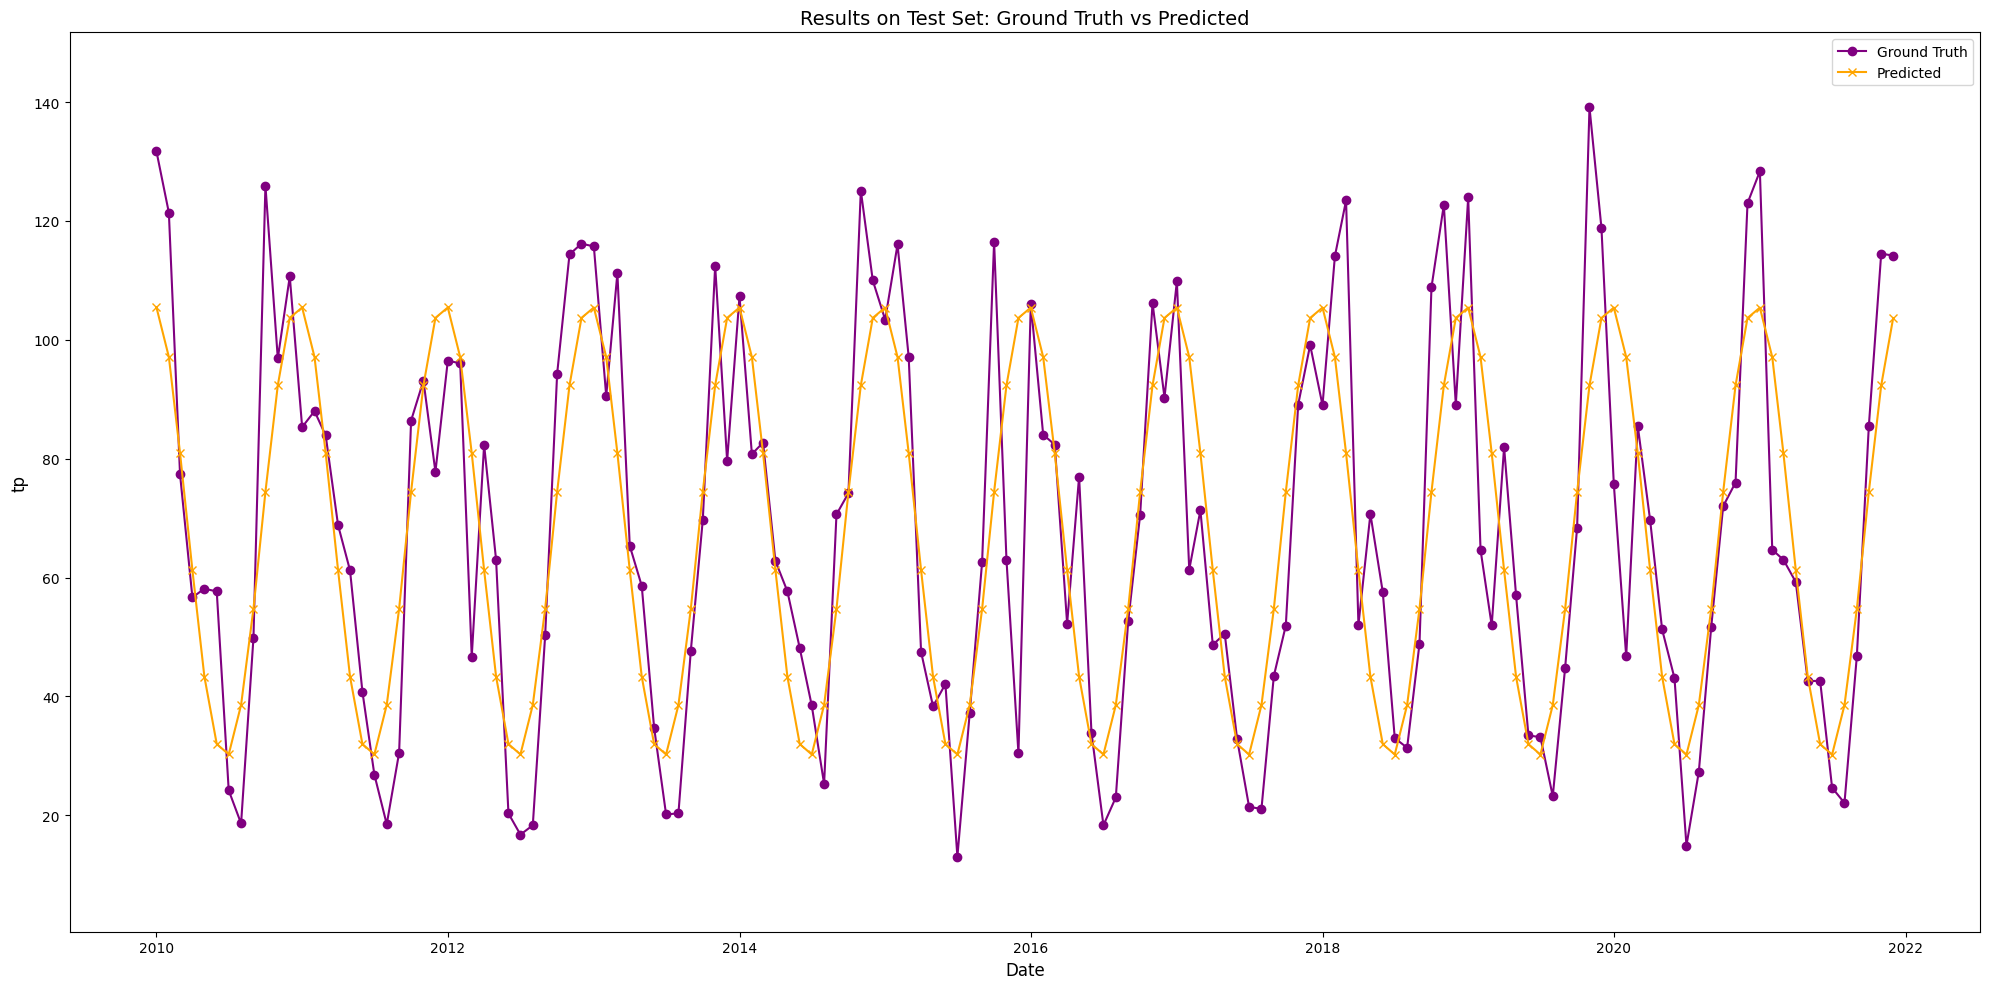

In [15]:
climatology.plot_yearly_results()    

## 3- ARIMA

### A- Time series tools

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

### 1. stationnarity

/scratch-local/69627/ipykernel_3699680/1617309279.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data_df, x='year', y='tp', ci=None)


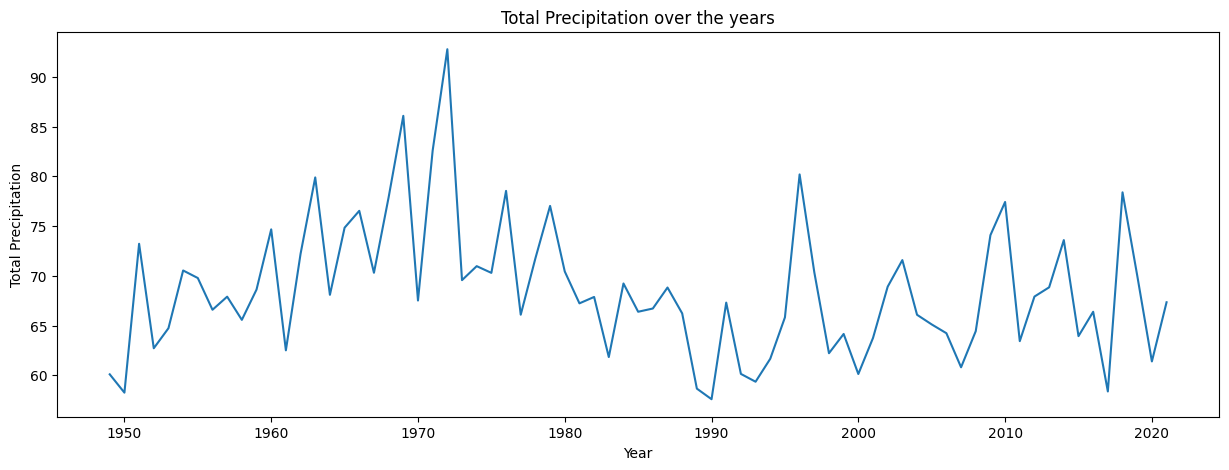

ADF Statistic: -5.582977
p-value: 0.000001


In [17]:
years_interest = list(range(1949,2022))

# # remove 1947 from train years
# ds_bis= ds.sel(time=years_interest)
# # faire la moyenne sur chaque année

data_df = pd.DataFrame()
for year in years_interest:
    year_data = ds.sel(time=str(year))
    if len(year_data.time) == 0:
        continue
    year_df = year_data.groupby('time.month').sum(dim=['time', 'latitude', 'longitude']).to_dataframe().reset_index()
    year_df['year'] = year
    data_df = pd.concat([data_df, year_df])

#plot the evolution of the sum of precipitation over the years
plt.figure(figsize=(15, 5))
sns.lineplot(data=data_df, x='year', y='tp', ci=None)
plt.title('Total Precipitation over the years')
plt.xlabel('Year')
plt.ylabel('Total Precipitation')
plt.show()


month_sum = data_df['tp'].values.flatten()



adf_test = adfuller(month_sum)
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

A p value under 0.05 indicates stationnarity

### 2. Autocorrelation

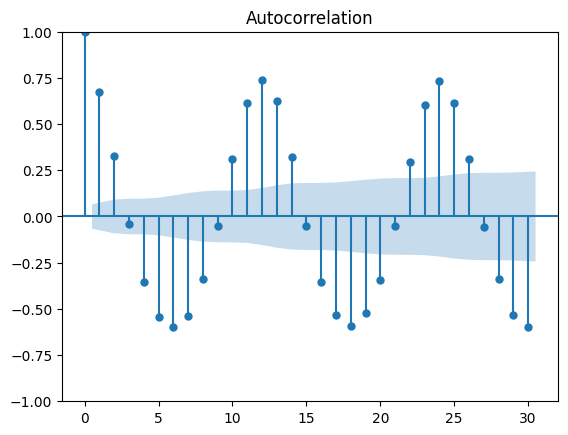

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 50 is around 40 years
plot_acf(month_sum, lags=30)
plt.show()

## 2- Arima

In [19]:

class ClimatologyARIMA:
    def __init__(self, data: xr.DataArray, var: str, split_years: dict):
        self.data = data
        self.split_years = split_years
        self.var = var
        # remove 1947 from train years
        self.train_years = split_years["train"]
        if 1947 in self.train_years:
            self.train_years.remove(1947)
        self.test_years = split_years["test"]
        self.model = None
        
        self._train_model()

    def _prepare_data(self, years):
        series = []
        for year in years:
            year_data = self.data.sel(time=str(year))
            if len(year_data.time) == 0:
                continue
            year_data = year_data.groupby('time.week').mean(dim=['time', 'latitude', 'longitude']) 
            series.append(year_data[self.var].values)
        
        return np.concatenate(series)

    def _train_model(self):
        self.train_series = self._prepare_data(self.train_years)
        # add exog regressors like year and month
        
        exog_regressors = 0
        self.model = ARIMA(self.train_series, order=(10,0,1))  # Example order, adjust as needed
        self.model = self.model.fit()
        print(self.model.summary())

    def predict(self, steps: int):
        forecast = self.model.get_forecast(steps=steps)
        return forecast.predicted_mean

    def evaluate(self):
        test_series = self._prepare_data(self.test_years)[:5]
        steps = 5
        predictions = self.predict(steps)
        
        mse = np.mean((test_series - predictions) ** 2)
        results = {'y_test': test_series, 'y_pred': predictions, 'mse': mse}
        
        return results

    def plot_test_results(self):
        results = self.evaluate()
        lenght = len(results['y_test'])
        test_dates = np.arange(0, lenght)
        y_test = results['y_test']
        y_pred = results['y_pred']

        plt.figure(figsize=(12, 6))
        plt.plot(test_dates, y_test, label='y_test', marker='o')
        plt.plot(test_dates, y_pred, label='y_pred', marker='x')
        plt.title('Test Results: Actual vs Predicted')
        plt.xlabel('Date')
        plt.ylabel(self.var)
        plt.legend()
        plt.show()


In [20]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

class ClimatologyARIMA:
    def __init__(self, data: xr.DataArray, var: str, split_years: dict):
        self.data = data
        self.split_years = split_years
        self.var = var
        # Remove 1947 from train years
        self.train_years = split_years["train"]
        if 1947 in self.train_years:
            self.train_years.remove(1947)
        self.test_years = split_years["test"]
        self.model = None

        self._train_model()

    def _prepare_data(self, years):
        series = []
        exog = []
        for year in years:
            year_data = self.data.sel(time=str(year))
            if len(year_data.time) == 0:
                continue
            year_data = year_data.groupby('time.week').mean(dim=['time', 'latitude', 'longitude'])
            values = year_data[self.var].values
            series.append(values)
            for week in range(len(values)):
                exog.append([year,week])
        
        series = np.concatenate(series)
        exog = np.array(exog)
        return series, exog

    def _train_model(self):
        self.train_series, self.train_exog = self._prepare_data(self.train_years)
        self.model = ARIMA(self.train_series, order=(5, 0, 1), exog=self.train_exog)  # Example order, adjust as needed
        self.model = self.model.fit()
        print(self.model.summary())

    def predict(self, steps: int, exog: np.ndarray):
        forecast = self.model.get_forecast(steps=steps, exog=exog)
        return forecast.predicted_mean

    def evaluate(self, nb_steps = 5):

        test_series, test_exog = self._prepare_data(self.test_years)
        test_series = test_series[:nb_steps]
        test_exog = test_exog[:nb_steps]
        predictions = self.predict(nb_steps, test_exog)
        
        mse = np.mean((test_series - predictions) ** 2)
        results = {'y_test': test_series, 'y_pred': predictions, 'mse': mse}
        
        return results

    def plot_test_results(self, nb_steps=5):
        results = self.evaluate(nb_steps= nb_steps)
        length = len(results['y_test'])
        test_dates = np.arange(0, length)
        y_test = results['y_test']
        y_pred = results['y_pred']

        plt.figure(figsize=(12, 6))
        plt.plot(test_dates, y_test, label='y_test', marker='o')
        plt.plot(test_dates, y_pred, label='y_pred', marker='x')
        plt.title('Test Results: Actual vs Predicted')
        plt.xlabel('Weeks')
        plt.ylabel(self.var)
        plt.legend()
        plt.show()

    def plot_continuous_curve(self, nb_steps=5):
        # Prepare training and test data
        train_series, train_exog = self._prepare_data(self.train_years)
        test_series, test_exog = self._prepare_data(self.test_years)

        # take only the past 4 years data
        train_series = train_series[-208:]
        train_exog = train_exog[-208:]
        

        # Make predictions
        predictions = self.predict(nb_steps, test_exog[:nb_steps])

        # Concatenate the training series and predictions
        full_series = np.concatenate([train_series, predictions])
        
        # Generate date range
        train_years = train_exog[:, 0]
        test_years = test_exog[:, 0]
        full_years = np.concatenate([train_years, test_years[:nb_steps]])
        # Concatenate the ground truth test series for plotting
        full_ground_truth = np.concatenate([train_series, test_series[:nb_steps]])

        # Plotting
        plt.figure(figsize=(15, 8))
        plt.plot(full_years, full_series, label='Model Predictions', marker='o')
        plt.plot(full_years, full_ground_truth, label='Ground Truth', marker='x')
        plt.axvline(x=self.train_years[-1], color='gray', linestyle='--', label='End of Training Data')
        plt.title('Training Data and Predictions')
        plt.xlabel('Years')
        plt.ylabel(self.var)
        plt.legend()
        plt.show()

            


In [21]:
arima = ClimatologyARIMA(ds, 'tp', split_years={"train": list(range(1940, 2010)), "test": list(range(2010, 2022))})
                    

/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3613
Model:                 ARIMA(5, 0, 1)   Log Likelihood               21772.404
Date:                Fri, 27 Sep 2024   AIC                         -43524.808
Time:                        12:18:46   BIC                         -43462.885
Sample:                             0   HQIC                        -43502.744
                               - 3613                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.005      0.318      0.750      -0.008       0.012
x1         -9.175e-08   2.57e-06     -0.036      0.972   -5.14e-06    4.95e-06
x2          1.802e-06   1.16e-06      1.557      0.1

In [22]:
arima.evaluate(nb_steps=10)

/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard

{'y_test': array([0.00286983, 0.00325662, 0.0028736 , 0.00243444, 0.00238617,
        0.00328969, 0.00329588, 0.00259048, 0.00249728, 0.00268716],
       dtype=float32),
 'y_pred': array([0.00234318, 0.00230496, 0.00227254, 0.00216162, 0.00205228,
        0.00199925, 0.00194206, 0.00189139, 0.00184336, 0.00180144]),
 'mse': 6.929104872728226e-07}

/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard

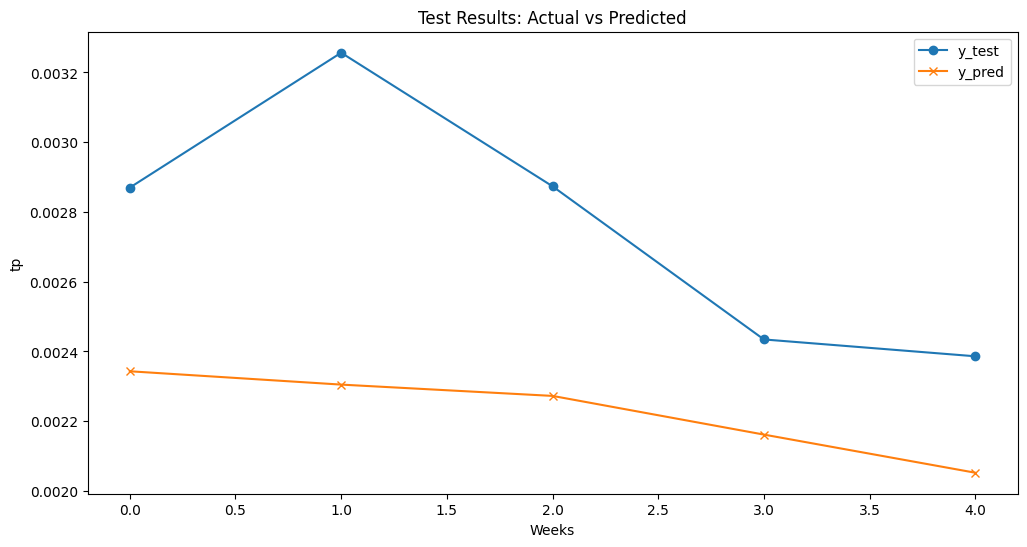

In [23]:
arima.plot_test_results(nb_steps=5)

/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/egauillard

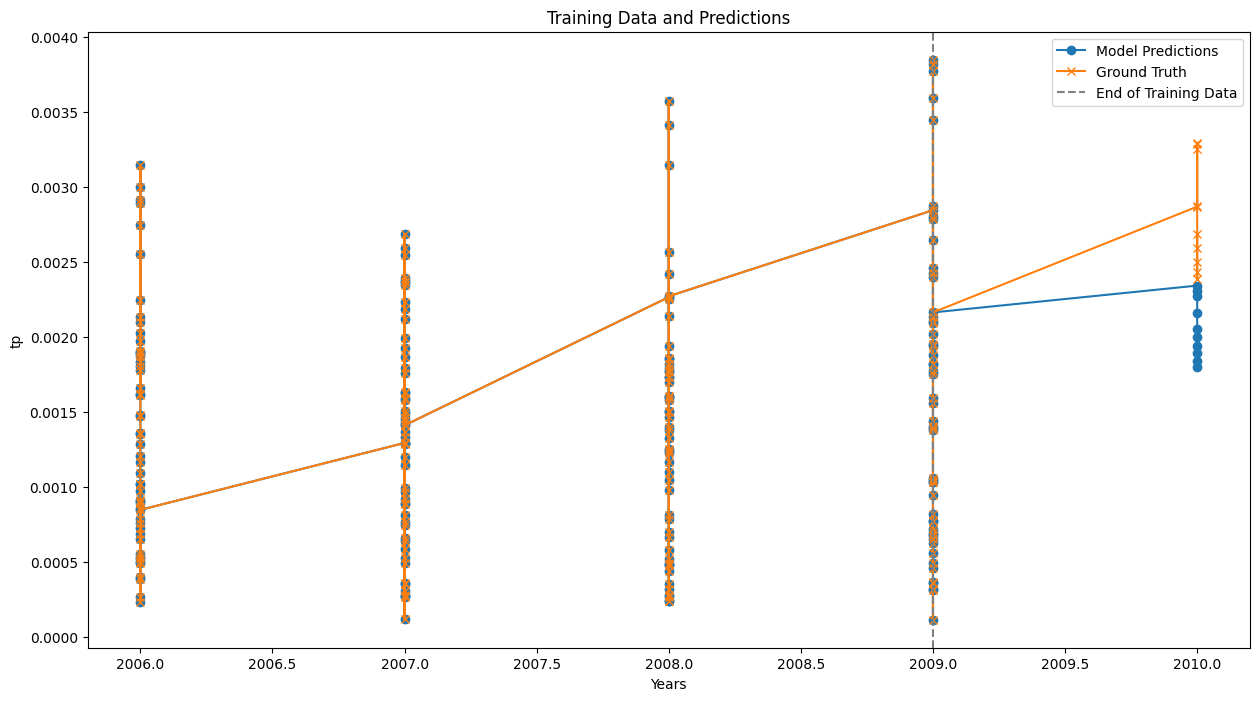

In [24]:
arima.plot_continuous_curve(nb_steps=10)